# Классификация: превышает ли значение SI медианное значение выборки

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    cross_validate
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    make_scorer
)
import optuna

In [3]:
df_clean = pd.read_csv("df_cleaned.csv")
df_clean.head(5)

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,2,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Смотрим размер дата сета
df_clean.shape

(980, 196)

In [5]:
IC50_COL  = "SI"
TARGET_COL = "SI_median"

# Находим медиану
si_median = df_clean[IC50_COL].median()
print(f"SI median: {si_median:.4g}")

# Бинарная целевая переменная: 1, если SI > медианы, иначе 0
df_clean[TARGET_COL] = (df_clean[IC50_COL] > si_median).astype(int)

SI median: 3.94


In [6]:
# Удаляем целевые переменные и не информативный признак 
X = df_clean.drop(['IC50, mM', 'SI', 'CC50, mM', 'Unnamed: 0', TARGET_COL], axis=1)
y = df_clean[TARGET_COL]

In [7]:
# автоматически отбираем признаки с важностью выше медианы, чтобы сократить размерность данных.
rf = RandomForestClassifier(n_estimators=80, random_state=42)
selector = SelectFromModel(rf, threshold="median")  
X_selected = selector.fit_transform(X, y)
X_selected.shape

(980, 96)

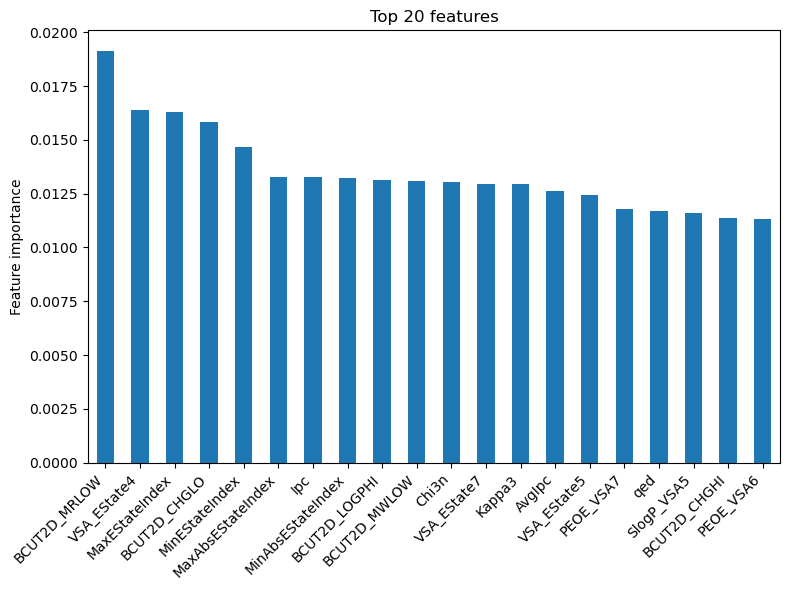

In [8]:
# названия и важности только для выбранных фич
mask            = selector.get_support()
selected_names  = X.columns[mask]
importances_sel = selector.estimator_.feature_importances_[mask]

# отсортируем и возьмём топ-20
feat_imp = (
    pd.Series(importances_sel, index=selected_names)
      .sort_values(ascending=False)
      .head(20)
)

# рисуем
plt.figure(figsize=(8, 6))
feat_imp.plot(kind="bar")
plt.ylabel("Feature importance")
plt.title("Top 20 features")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

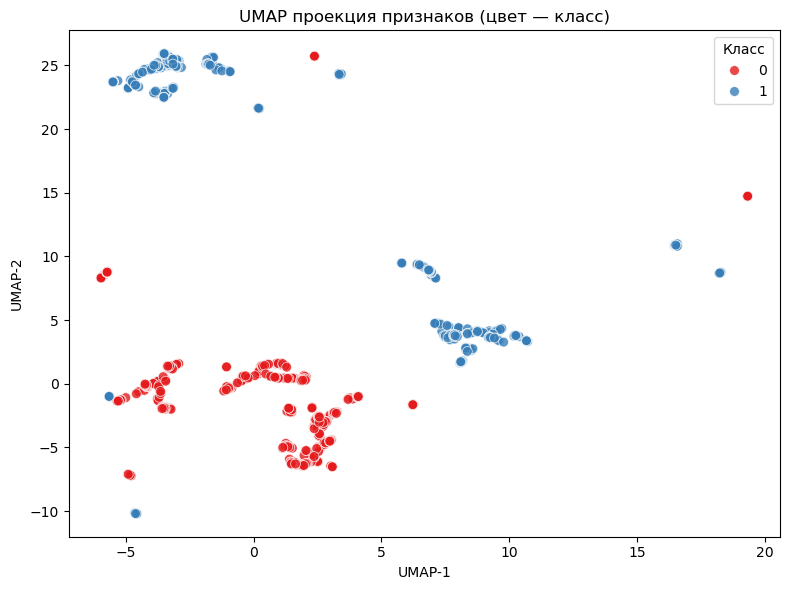

In [9]:
# Масштабирование
X_scaled = StandardScaler().fit_transform(X_selected)

# UMAP проекция в 2D
reducer = umap.UMAP(n_neighbors=30, min_dist=0.05, metric="cosine")
X_umap = reducer.fit_transform(X_scaled, y)

# Визуализация
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette="Set1", s=50, alpha=0.8)
plt.title("UMAP проекция признаков (цвет — класс)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Класс")
plt.tight_layout()
plt.show()

In [10]:
# разделим данные на тренировачную и тестовую подвыбарку 
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [11]:
# Выводим распределение классов в обучающей выборке (в процентах)
class_dist = y_train.value_counts(normalize=True) * 100
print(f"\nРаспределение классов в обучающей выборке:\n"
      f"  SI > медианы: {class_dist[0]:.2f}%\n"
      f"  SI < медианы: {class_dist[1]:.2f}%")


Распределение классов в обучающей выборке:
  SI > медианы: 48.98%
  SI < медианы: 51.02%


In [12]:
# Список моделей для обучения
base_models_cls = {
    "RandomForest":  RandomForestClassifier(random_state=42, n_jobs=-1),
    "ExtraTrees":    ExtraTreesClassifier(random_state=42, n_jobs=-1),
    "HistGBC":       HistGradientBoostingClassifier(random_state=42),
    "XGBoost":       XGBClassifier(random_state=42),
    "LightGBM":      LGBMClassifier(verbosity=-1, random_state=42),
    "CatBoost":      CatBoostClassifier(random_state=42, verbose=0),
}

# Оборачиваем каждую модель в Pipeline (scaler + модель)
models = {
    name: Pipeline([
        ("scaler", StandardScaler()),
        ("model", mdl)
    ])
    for name, mdl in base_models_cls.items()
}

# Кросс-валидация и метрики
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
SCORERS = {
    "accuracy":  "accuracy",
    "precision": "precision",
    "recall":    "recall",
    "f1":        "f1",
    "roc_auc":   "roc_auc"
}

results = {}

for name, pipe in models.items():
    print(f"Обучение {name}...")
    cv_res = cross_validate(
        pipe,
        X_train,           # уже готовый train-split
        y_train,
        cv=CV,
        scoring=SCORERS,
        n_jobs=-1,
        return_estimator=False
    )
    # усредняем метрики
    results[name] = {m: (cv_res[f'test_{m}'].mean(), cv_res[f'test_{m}'].std())
                     for m in SCORERS.keys()}
    print("  " + " | ".join(
        f"{m}: {mean:.3f}±{std:.3f}" for m, (mean, std) in results[name].items()
    ))

Обучение RandomForest...
  accuracy: 0.647±0.022 | precision: 0.660±0.038 | recall: 0.648±0.054 | f1: 0.651±0.022 | roc_auc: 0.706±0.026
Обучение ExtraTrees...
  accuracy: 0.639±0.042 | precision: 0.660±0.064 | recall: 0.633±0.062 | f1: 0.641±0.032 | roc_auc: 0.685±0.037
Обучение HistGBC...
  accuracy: 0.665±0.031 | precision: 0.674±0.041 | recall: 0.675±0.052 | f1: 0.672±0.029 | roc_auc: 0.697±0.024
Обучение XGBoost...
  accuracy: 0.638±0.022 | precision: 0.647±0.038 | recall: 0.653±0.046 | f1: 0.647±0.016 | roc_auc: 0.682±0.022
Обучение LightGBM...
  accuracy: 0.651±0.030 | precision: 0.661±0.043 | recall: 0.662±0.064 | f1: 0.658±0.032 | roc_auc: 0.696±0.023
Обучение CatBoost...
  accuracy: 0.668±0.036 | precision: 0.681±0.055 | recall: 0.680±0.079 | f1: 0.675±0.036 | roc_auc: 0.719±0.033


In [13]:
# Итоговая таблица mean ± std
summary = pd.DataFrame({
    (metric, stat): {
        model: results[model][metric][0] if stat == "mean" else results[model][metric][1]
        for model in results
    }
    for metric in SCORERS.keys()
    for stat in ["mean", "std"]
}).sort_values(("f1", "mean"), ascending=False)

print("\nСравнение моделей (CV, mean ± std):")
display(summary)


Сравнение моделей (CV, mean ± std):


accuracy           precision            recall            \
                  mean       std      mean       std    mean       std   
CatBoost      0.668447  0.036107  0.681335  0.055051  0.6800  0.078502   
HistGBC       0.664584  0.030666  0.673509  0.040872  0.6750  0.052440   
LightGBM      0.650563  0.030238  0.660695  0.042558  0.6625  0.063738   
RandomForest  0.646725  0.022397  0.659857  0.037803  0.6475  0.053852   
XGBoost       0.637792  0.022007  0.647039  0.037724  0.6525  0.045689   
ExtraTrees    0.639066  0.041886  0.660018  0.063529  0.6325  0.062048   

                    f1             roc_auc            
                  mean       std      mean       std  
CatBoost      0.675412  0.035940  0.719383  0.032561  
HistGBC       0.672014  0.029430  0.696554  0.023829  
LightGBM      0.658229  0.031915  0.695795  0.022824  
RandomForest  0.650937  0.021710  0.706182  0.026138  
XGBoost       0.647310  0.016336  0.681840  0.021885  
ExtraTrees    0.640968  0.032313  0.684794  0.036912

In [14]:
# Список результатов метрик
test_results = {}

# Предсказания и метрики
all_conf_matrices = {}

for name, pipe in models.items():    
    # Обучение
    pipe.fit(X_train, y_train)
    
    # Предсказания
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps['model'], "predict_proba") else None

    # Метрики
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    roc  = roc_auc_score(y_test, y_proba) if y_proba is not None else float('nan')

    test_results[name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc
    }
    # Сохраняем confusion matrix для последующего вывода
    all_conf_matrices[name] = confusion_matrix(y_test, y_pred)

In [15]:
# Таблица метрик на тестовой выборке
test_summary_df = pd.DataFrame(test_results).T
test_summary_df = test_summary_df.round(3)  

print("\n Сводная таблица метрик на тестовой выборке:")
display(test_summary_df.sort_values("f1", ascending=False))


 Сводная таблица метрик на тестовой выборке:


,accuracy,precision,recall,f1,roc_auc
LightGBM,0.663,0.620,0.689,0.653,0.702
XGBoost,0.648,0.604,0.678,0.639,0.710
CatBoost,0.653,0.612,0.667,0.638,0.713
HistGBC,0.633,0.587,0.678,0.629,0.695
RandomForest,0.638,0.600,0.633,0.616,0.692
ExtraTrees,0.622,0.582,0.633,0.606,0.695



 Confusion matrices:


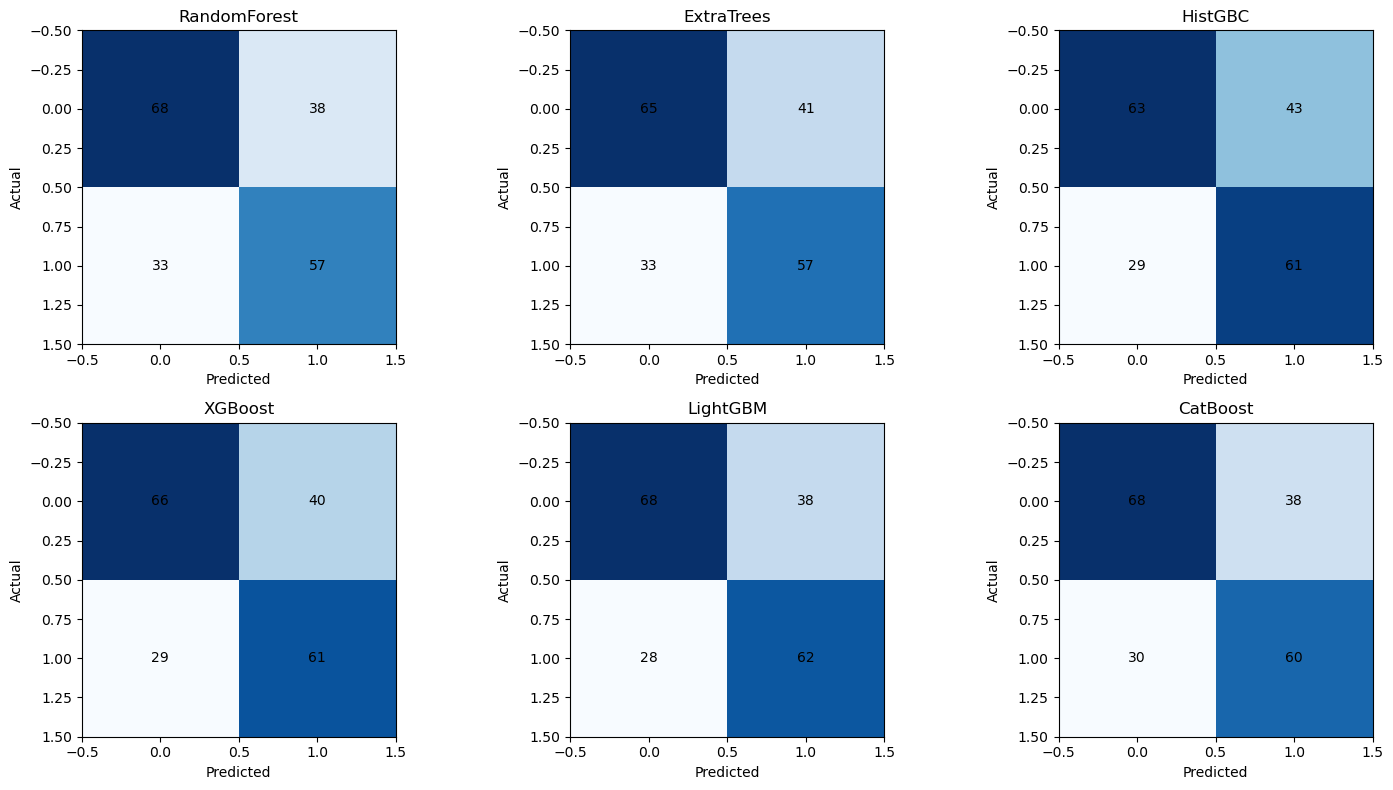

In [16]:
# Визуализация confusion matrix
print("\n Confusion matrices:")

n_models = len(all_conf_matrices)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for idx, (name, cm) in enumerate(all_conf_matrices.items()):
    ax = axes[idx]
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

# Удаляем лишние оси
for i in range(len(all_conf_matrices), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [17]:
# CV-стратегия и скорер
CV     = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
SCORER = make_scorer(f1_score, zero_division=0)

# функция генерации параметров
def suggest_rf_params(trial):
    return {
        "n_estimators"     : trial.suggest_int("n_estimators", 100, 800, step=100),
        "max_depth"        : trial.suggest_categorical("max_depth", [None, *range(3, 31)]),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features"     : trial.suggest_categorical("max_features", ["sqrt", "log2", 0.5, None]),
        "bootstrap"        : trial.suggest_categorical("bootstrap", [True, False]),
        "class_weight"     : trial.suggest_categorical("class_weight", [None, "balanced", "balanced_subsample"]),
        "random_state"     : 42,
        "n_jobs"           : -1,
    }

def objective(trial):
    model  = RandomForestClassifier(**suggest_rf_params(trial))
    score  = cross_val_score(model, X_train, y_train,
                             cv=CV, scoring=SCORER, n_jobs=-1).mean()
    return score

# запуск оптимизации
study = optuna.create_study(direction="maximize", study_name="RF_F1")
study.optimize(objective, n_trials=50, timeout=600, show_progress_bar=True)

print("Лучшие параметры:\n", study.best_params)
print("Лучшая F1 (CV):", round(study.best_value, 4))

# финальная модель
best_rf = RandomForestClassifier(**study.best_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train, y_train)

[I 2025-06-15 17:34:04,961] A new study created in memory with name: RF_F1


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-15 17:34:05,302] Trial 0 finished with value: 0.6636110944066925 and parameters: {'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6636110944066925.
[I 2025-06-15 17:34:05,935] Trial 1 finished with value: 0.6570817550478413 and parameters: {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 0 with value: 0.6636110944066925.
[I 2025-06-15 17:34:07,666] Trial 2 finished with value: 0.6557018749030704 and parameters: {'n_estimators': 700, 'max_depth': 15, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.6636110944066925.
[I 2025-06-15 17:34:08,813] Trial 3 finished with value: 0.6631085427845766 and parameters: {'n_estima

RandomForestClassifier(max_depth=18, min_samples_leaf=4, n_estimators=500,
                       n_jobs=-1, random_state=42)

Метрики на тестовой выборке:


,Accuracy,Precision,Recall,F1-score,ROC AUC
0,0.653,0.62,0.633,0.626,0.706


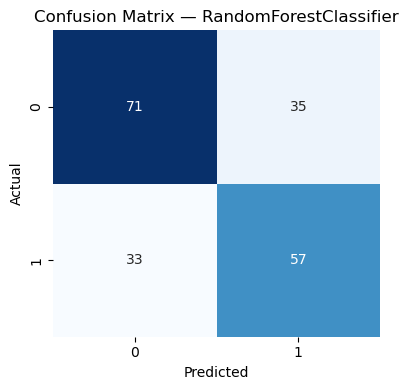

In [18]:
# Предсказания
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

# Метрики
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
roc  = roc_auc_score(y_test, y_proba)

# Таблица метрик
metrics_df = pd.DataFrame({
    "Accuracy": [acc],
    "Precision": [prec],
    "Recall": [rec],
    "F1-score": [f1],
    "ROC AUC": [roc]
}).round(3)

print("Метрики на тестовой выборке:")
display(metrics_df)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — RandomForestClassifier")
plt.tight_layout()
plt.show()
